## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [7]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
# YOUR CODE HERE!
df_ticker = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Display sample data
df_ticker.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,55.40,55.45,54.98,54.99,4881442,30491,55.201737,NKE
2017-05-02 04:00:00+00:00,55.16,55.16,54.79,55.07,7363885,41589,54.967165,NKE
2017-05-03 04:00:00+00:00,55.17,55.30,54.40,54.53,9486619,48477,54.622933,NKE
2017-05-04 04:00:00+00:00,54.69,54.83,54.20,54.47,6830628,39260,54.501544,NKE
2017-05-05 04:00:00+00:00,54.49,54.50,53.56,53.95,13379949,57959,53.889567,NKE


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [8]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   

                                        NKE                ...            \
                                vwap   open   high    low  ...    volume   
timestamp                                                  ...             
2017-05-01 04:00:00+00:00  39.278779  55.40  55.45  54.98  ...   4881442   
2017-05-02 04:00:00+00:00  38.996448  55.16  55.16  54.79  ...   7363885   
2017-05-03 04:00:00+00:00  38.423685  55.17  55.30  54.40  ...   9486619   
2017-05-04 04:00:00+00:00  37.965109  54.69  54.83  54.20  ...   6830628   
2017-05-05 04:00:00+00:00  38.424403  54.49  54.50  53.56  ...  13379949   

                                                    XOM                  \
                          trade_count       vwap   open     high    low   
timestamp                                                                 
2017-05-01 04:00:00+00:00       30491  55.201737  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00       41589  54.967165  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00       48477  54.622933  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00       39260  54.501544  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00       57959  53.889567  81.63  82.2350  81.61   

                                                                   
                           close    volume trade_count       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [14]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
# YOUR CODE HERE!
MC_fouryear = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.60,.20,.20],
    num_simulation = 500,
    num_trading_days = 252*4
)
# Print the simulation input data
MC_fouryear.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.40  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.16  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.69  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.49  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [15]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
# YOUR CODE HERE!
MC_fouryear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\P630461\Documents\FinTech-Bootcamp\FinTechBC-ClassActivity\5.3\04-Stu_Three_Stock_Monte\Unsolved\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005702,1.001088,0.985165,0.997389,0.987889,0.996821,0.994429,0.993921,0.999871,1.016455,...,1.001375,1.002857,0.998745,0.984063,1.002837,0.989902,0.989395,0.993240,0.988689,0.986979
2,1.006515,1.024373,0.979071,1.009042,0.997520,0.989881,1.012992,0.988547,0.987135,1.028013,...,0.994602,1.003671,1.020088,0.997372,1.012991,0.978453,0.988426,1.004693,0.997590,0.980388
3,0.989316,1.010308,0.982919,1.008986,1.005257,0.994321,1.003549,0.971971,0.965560,1.036226,...,1.001348,1.010377,1.004103,0.982772,1.021688,0.958549,0.978004,0.991962,1.000817,0.970524
4,0.996753,1.008087,0.978067,1.021762,0.994691,0.982544,1.010349,0.977149,0.957654,1.024043,...,0.992107,1.012646,1.010995,0.953394,1.029921,0.969462,0.975481,0.978368,1.011182,0.965487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,0.895625,1.194450,1.205574,1.591641,1.420683,1.060943,0.915196,1.020155,1.846732,0.572862,...,0.851702,0.670448,1.230470,1.580809,1.921604,1.519095,0.466190,0.974398,0.862158,1.444251
1005,0.886301,1.180121,1.209324,1.591668,1.430666,1.084273,0.925145,1.029714,1.885506,0.570858,...,0.864546,0.668282,1.203952,1.582207,1.910670,1.503913,0.456562,0.988388,0.865293,1.435967
1006,0.887786,1.159472,1.221222,1.591801,1.437645,1.083776,0.932106,1.021373,1.889019,0.582685,...,0.882133,0.674981,1.203607,1.574412,1.922733,1.477844,0.455419,0.993160,0.861897,1.455574
1007,0.899506,1.151331,1.223461,1.584702,1.426750,1.076894,0.930798,1.024505,1.900255,0.586809,...,0.877687,0.675012,1.213918,1.595979,1.883791,1.473949,0.455999,1.010862,0.858023,1.469473


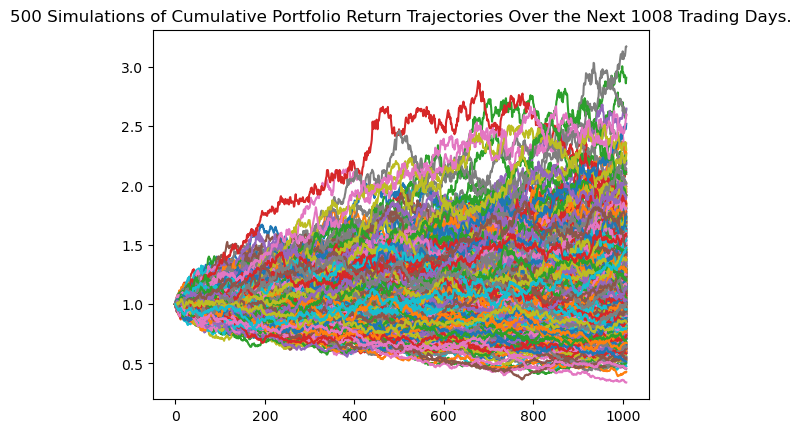

In [16]:
# Plot simulation outcomes
line_plot = MC_fouryear.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_fouryear_sim_plot.png", bbox_inches="tight")

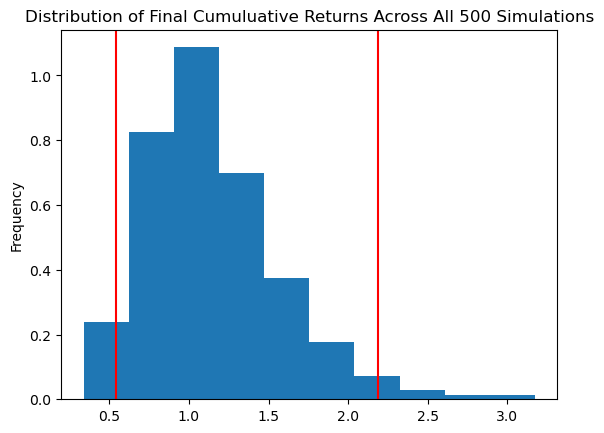

In [17]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!
dist_plot = MC_fouryear.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fouryear_dist_plot.png',bbox_inches='tight')

In [18]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!
tbl = MC_fouryear.summarize_cumulative_return()

# Print summary statistics
print(tbl)
# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.153025
std               0.427691
min               0.339854
25%               0.851251
50%               1.090815
75%               1.364175
max               3.173540
95% CI Lower      0.539164
95% CI Upper      2.188032
Name: 1008, dtype: float64


In [20]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
# YOUR CODE HERE!
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 4 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 4 years will end within in the range of $5391.64 and $21880.32


### Simulate five year portfolio growth with 60% AT&T stock

In [12]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
# YOUR CODE HERE!

# Print the simulation input data
MC_att.portfolio_data.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95238  39.69  24750447   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86237  39.15  24852467   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113920  38.94  33743554   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118191  38.38  31450002   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82070  38.06  21829853   

                                                     NKE         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  54.99  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.07  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  54.53  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.47  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  53.95  54.50  ...   

                                                     XOM                  \
                                vwap daily_return  close     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  82.02  82.2350  81.61   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49226  81.56   8664579  81.941004          NaN  
2017-05-02 04:00:00+00:00       54234  82.17   9102893  82.197909    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.97  10289447  82.625679     0.007922  
2017-05-04 04:00:00+00:00       86289  82.28  16165093  81.729800    -0.012817  
2017-05-05 04:00:00+00:00       59397  81.63  10212004  81.932657     0.004655  

[5 rows x 24 columns]

In [13]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001097,1.005043,0.999391,1.004701,1.017001,0.974727,0.998481,0.981011,1.005864,1.004682,...,1.005040,1.002232,1.007500,0.998868,1.000105,1.001074,1.000249,0.988702,0.987680,0.987503
2,1.005449,1.010285,1.005221,1.002673,1.030108,0.981966,0.996166,0.998531,1.005890,0.997490,...,1.030361,0.992666,1.004757,0.996640,1.000543,0.988598,0.998475,0.988409,0.982752,0.991572
3,1.004448,1.024297,1.013651,1.001207,1.036539,0.970496,1.007539,1.007840,1.008970,1.009152,...,1.043972,0.997780,0.997681,0.992883,0.996404,0.982341,1.008847,0.997836,0.977185,0.977294
4,0.991645,1.039895,1.000231,1.001619,1.059643,0.967109,1.001706,0.997919,0.997606,1.006274,...,1.049366,0.964390,1.000459,0.987321,0.998709,0.989999,1.040977,1.003392,0.968699,0.982367
5,0.994519,1.029013,0.991454,1.015898,1.070898,0.945905,1.014519,0.983187,0.992130,1.013028,...,1.051454,0.986094,1.008954,0.984315,0.996117,1.002924,1.037982,1.017834,0.981152,0.989024
6,0.983213,1.022768,0.991815,1.030379,1.073939,0.959457,1.026571,0.975236,0.996264,1.010733,...,1.060071,0.978522,1.012869,0.991490,1.007945,1.007747,1.059014,1.011357,0.969910,0.992585
7,0.989883,1.022961,0.975497,1.001517,1.071341,0.950927,1.020368,0.988964,1.010474,1.001137,...,1.057984,1.003106,1.025340,0.984719,1.018575,1.011288,1.064427,1.016754,0.952493,0.988475
8,1.000940,1.025241,0.992369,0.997563,1.072780,0.969709,1.030861,0.979402,1.029918,1.006926,...,1.052890,0.992163,1.042576,0.994131,1.010600,1.002271,1.088946,1.042488,0.948222,0.982005
9,1.002959,1.017130,0.999941,0.993585,1.057194,0.960904,1.019357,0.980902,1.039324,1.018859,...,1.042327,1.001744,1.041603,1.002475,1.032092,1.011567,1.099589,1.032519,0.975277,0.994847


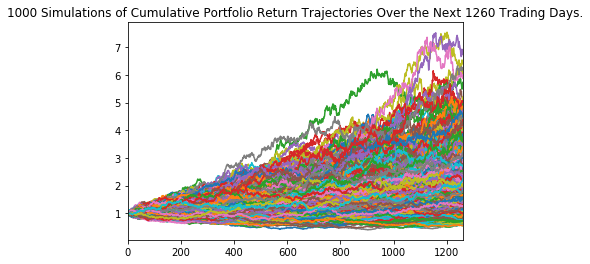

In [14]:
# Plot simulation outcomes
# YOUR CODE HERE!

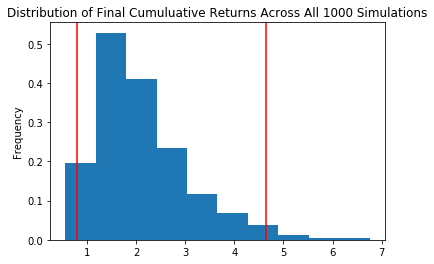

In [15]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [16]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           1000.000000
mean               2.118563
std                0.967939
min                0.559486
25%                1.413529
50%                1.896227
75%                2.602504
max                6.750983
95% CI Lower       0.798545
95% CI Upper       4.637593
Name: 1260, dtype: float64


In [17]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $11978.17 and $69563.89.


### Simulate five year portfolio growth with 60% Nike stock

In [18]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
# YOUR CODE HERE!

# Printing the simulation input data
MC_nike.portfolio_data.head()

T                                             \
                           close   high    low trade_count   open    volume   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.10  39.70  39.06       95238  39.69  24750447   
2017-05-02 04:00:00+00:00  38.95  39.22  38.88       86237  39.15  24852467   
2017-05-03 04:00:00+00:00  38.40  38.98  38.15      113920  38.94  33743554   
2017-05-04 04:00:00+00:00  38.01  38.41  37.63      118191  38.38  31450002   
2017-05-05 04:00:00+00:00  38.56  38.71  38.03       82070  38.06  21829853   

                                                     NKE         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  54.99  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.07  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  54.53  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.47  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  53.95  54.50  ...   

                                                     XOM                  \
                                vwap daily_return  close     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  82.06  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.05  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  82.70  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  81.64  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  82.02  82.2350  81.61   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00       49226  81.56   8664579  81.941004          NaN  
2017-05-02 04:00:00+00:00       54234  82.17   9102893  82.197909    -0.000122  
2017-05-03 04:00:00+00:00       57309  81.97  10289447  82.625679     0.007922  
2017-05-04 04:00:00+00:00       86289  82.28  16165093  81.729800    -0.012817  
2017-05-05 04:00:00+00:00       59397  81.63  10212004  81.932657     0.004655  

[5 rows x 24 columns]

In [19]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.989258,0.991313,0.999952,1.015257,1.003894,0.996969,1.016278,1.005308,0.968730,0.992732,...,0.990555,0.996806,1.000709,1.004595,1.016982,0.998551,1.015862,0.998269,0.997426,1.013568
2,1.000837,0.992767,1.004443,1.022809,1.008063,0.997798,1.008575,0.992651,0.968501,0.971351,...,0.994021,0.996475,1.015835,0.995177,1.026042,0.997250,1.023982,0.992138,0.990940,1.016054
3,0.993153,0.985276,1.011351,1.048996,1.008551,0.978744,1.018904,0.994662,0.957480,0.960249,...,1.008749,1.005788,1.022118,1.002362,1.048429,0.999826,1.007399,1.017402,0.990086,1.001789
4,0.971504,0.992106,1.006075,1.065744,1.017701,0.980247,1.026764,0.990125,0.980740,0.965791,...,1.006629,1.018014,1.030292,1.027191,1.039234,0.997304,1.000348,0.993199,0.976446,1.006521
5,0.964791,0.994888,1.025431,1.064299,1.010869,0.987412,1.021009,0.995858,0.979022,0.972264,...,1.007943,1.014479,1.016614,1.030977,1.036311,0.994050,0.990048,0.999960,0.976458,1.003733
6,0.966272,0.981479,1.033325,1.076660,1.000878,0.995443,1.034408,0.993776,0.964014,0.969608,...,1.010864,1.041059,1.013796,1.033061,1.044007,0.990944,0.996390,1.000451,1.003530,0.976888
7,0.982108,0.997016,1.023678,1.078787,0.987604,1.004570,1.036285,1.008032,0.960606,0.972298,...,0.997557,1.034560,1.017188,1.025910,1.055168,0.984077,0.985642,0.996181,1.000288,0.968508
8,0.982472,1.006756,1.009158,1.083057,0.996901,0.997958,1.011200,1.024757,0.965521,0.962753,...,0.996595,1.042775,1.024392,1.038792,1.054505,0.986578,0.985554,0.989780,1.017837,0.985954
9,0.972664,1.012056,1.010964,1.079559,0.976176,0.985773,1.011139,1.017134,0.950392,0.948562,...,0.993504,1.059459,1.036010,1.025015,1.071442,0.975094,0.969501,0.990955,1.016710,0.989770


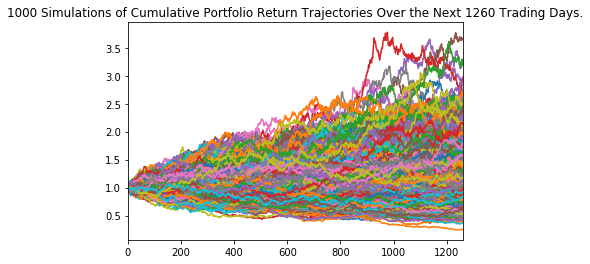

In [20]:
# Plot simulation outcomes
# YOUR CODE HERE!

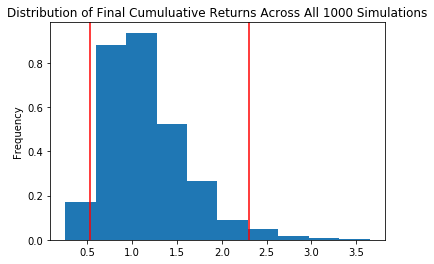

In [21]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           1000.000000
mean               1.150714
std                0.456782
min                0.252485
25%                0.821371
50%                1.061562
75%                1.387930
max                3.648969
95% CI Lower       0.524783
95% CI Upper       2.302636
Name: 1260, dtype: float64


In [23]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $7871.75 and $34539.55.


### Simulate five year portfolio growth with 60% Exxon stock

In [24]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
# YOUR CODE HERE!

# Printing the simulation input data
MC_exxon.portfolio_data

T                                       \
                           close     high      low trade_count   open   
timestamp                                                               
2017-05-01 04:00:00+00:00  39.10  39.7000  39.0600       95238  39.69   
2017-05-02 04:00:00+00:00  38.95  39.2200  38.8800       86237  39.15   
2017-05-03 04:00:00+00:00  38.40  38.9800  38.1500      113920  38.94   
2017-05-04 04:00:00+00:00  38.01  38.4100  37.6300      118191  38.38   
2017-05-05 04:00:00+00:00  38.56  38.7100  38.0300       82070  38.06   
2017-05-08 04:00:00+00:00  38.57  38.7800  38.3200       71580  38.70   
2017-05-09 04:00:00+00:00  38.22  38.5500  38.1600       73682  38.53   
2017-05-10 04:00:00+00:00  38.45  38.6500  38.1300       83938  38.20   
2017-05-11 04:00:00+00:00  38.44  38.5500  38.2149       62063  38.45   
2017-05-12 04:00:00+00:00  38.49  38.6100  38.3100       54991  38.49   
2017-05-15 04:00:00+00:00  38.59  38.6900  38.4100       77960  38.49   
2017-05-16 04:00:00+00:00  38.19  38.7600  38.1900       80610  38.66   
2017-05-17 04:00:00+00:00  37.46  38.0400  37.4500      108325  38.00   
2017-05-18 04:00:00+00:00  37.95  38.1400  37.4600       99533  37.49   
2017-05-19 04:00:00+00:00  38.24  38.2900  37.8900       68733  38.04   
2017-05-22 04:00:00+00:00  38.25  38.3500  38.1700       56224  38.23   
2017-05-23 04:00:00+00:00  38.31  38.4150  38.2100       51601  38.27   
2017-05-24 04:00:00+00:00  38.15  38.3600  38.0800       66316  38.32   
2017-05-25 04:00:00+00:00  38.23  38.3400  38.1100       62479  38.12   
2017-05-26 04:00:00+00:00  38.12  38.2500  38.0100       53042  38.22   
2017-05-30 04:00:00+00:00  38.55  38.6800  38.1900       72366  38.22   
2017-05-31 04:00:00+00:00  38.53  38.8700  38.5100       72019  38.67   
2017-06-01 04:00:00+00:00  38.87  38.8900  38.5200       76348  38.67   
2017-06-02 04:00:00+00:00  38.87  39.0800  38.7600       65242  39.00   
2017-06-05 04:00:00+00:00  38.81  38.8600  38.5700       56637  38.77   
2017-06-06 04:00:00+00:00  38.73  38.9200  38.6500       60308  38.75   
2017-06-07 04:00:00+00:00  38.76  38.8700  38.5400       65853  38.80   
2017-06-08 04:00:00+00:00  38.50  38.8400  38.4200       75514  38.81   
2017-06-09 04:00:00+00:00  38.79  38.8000  38.5510       75070  38.62   
2017-06-12 04:00:00+00:00  39.07  39.3700  38.8000       87688  38.81   
...                          ...      ...      ...         ...    ...   
2021-03-19 04:00:00+00:00  29.76  30.0600  29.6200      142480  30.01   
2021-03-22 04:00:00+00:00  29.99  30.0100  29.5800      121175  29.76   
2021-03-23 04:00:00+00:00  30.00  30.2650  29.8100      126020  29.91   
2021-03-24 04:00:00+00:00  29.99  30.2900  29.9700      127387  29.98   
2021-03-25 04:00:00+00:00  30.08  30.1850  29.8100      120799  30.12   
2021-03-26 04:00:00+00:00  30.31  30.6000  30.0750      198895  30.25   
2021-03-29 04:00:00+00:00  30.56  30.6457  30.2200      140361  30.32   
2021-03-30 04:00:00+00:00  30.73  30.7400  30.3950      126775  30.60   
2021-03-31 04:00:00+00:00  30.27  30.6500  30.2000      156228  30.60   
2021-04-01 04:00:00+00:00  30.47  30.4800  30.0300      133729  30.18   
2021-04-05 04:00:00+00:00  30.71  30.8400  30.6000      134450  30.60   
2021-04-06 04:00:00+00:00  30.98  30.9800  30.6900      124920  30.70   
2021-04-07 04:00:00+00:00  30.93  31.1500  30.8000      129996  31.00   
2021-04-08 04:00:00+00:00  30.00  30.3400  29.9300      153989  30.22   
2021-04-09 04:00:00+00:00  30.04  30.1900  29.9100      114163  30.00   
2021-04-12 04:00:00+00:00  29.96  30.1600  29.9000       99898  30.02   
2021-04-13 04:00:00+00:00  29.63  29.8600  29.5100      156402  29.78   
2021-04-14 04:00:00+00:00  29.73  29.7950  29.3000      132449  29.57   
2021-04-15 04:00:00+00:00  29.75  29.8400  29.6800      106841  29.75   
2021-04-16 04:00:00+00:00  29.95  30.0300  29.8400      104455  29.91   
2021-04-19 04:00:00+00:00  29.99  30.0750  29.8100       99969  30.02   
2021-04-20 04:00

In [25]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992692,1.001644,1.001438,0.999830,0.980606,1.002671,0.989576,0.986694,1.001668,1.012217,...,0.995995,0.990355,1.007622,1.012859,1.023809,1.003380,1.009408,0.989482,1.014174,1.005577
2,0.998005,0.989859,0.989061,1.009927,0.972915,1.004126,0.995139,0.970411,0.981734,1.031035,...,0.998114,0.992753,1.000371,1.002225,1.037693,1.001266,1.007647,0.988189,1.018176,0.996912
3,0.992190,0.991419,0.968902,1.016031,0.948651,1.002758,0.986155,0.970946,0.980997,1.032353,...,1.002744,0.992562,0.998632,0.995027,1.063302,0.991588,1.014565,0.983356,1.019189,1.004558
4,0.978410,0.982797,0.976945,1.016873,0.934817,0.993007,0.981827,0.964997,0.994139,1.055150,...,1.008927,0.992656,1.023620,0.985825,1.056365,0.977197,1.002412,0.975182,1.015650,0.999184
5,0.998603,0.999417,0.992792,1.012582,0.928435,0.983151,0.979181,0.966821,0.978530,1.051705,...,1.013831,0.974927,1.042005,0.982458,1.036214,0.983496,1.009531,0.984750,1.011478,0.977147
6,1.008358,1.006761,0.997066,1.011206,0.931277,0.974921,0.993160,0.984804,0.997681,1.043796,...,1.003782,0.991423,1.033880,0.984724,1.042754,0.977342,0.999804,0.977779,1.005554,0.956024
7,1.017398,1.008375,0.978376,1.007856,0.945470,0.960913,0.995197,0.988542,0.986594,1.010514,...,0.992231,0.959827,1.044880,0.974553,1.026351,0.997253,0.996353,0.977897,1.016381,0.963685
8,1.009726,1.012915,0.951503,0.995171,0.939055,0.958856,1.004391,1.005900,1.004587,1.001459,...,1.001244,0.967708,1.049657,0.961648,1.009606,0.988993,1.002587,0.970596,1.031231,0.972564
9,1.009505,1.017078,0.945064,0.987962,0.929587,0.959319,1.025573,1.007914,1.001854,0.999065,...,1.001134,0.993495,1.068961,0.964336,1.003132,0.978279,1.004707,0.970262,1.021499,0.964377


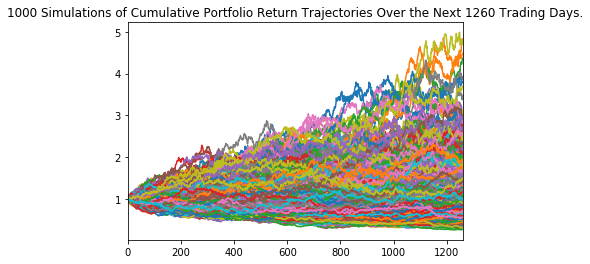

In [26]:
# Plot simulation outcomes
# YOUR CODE HERE!

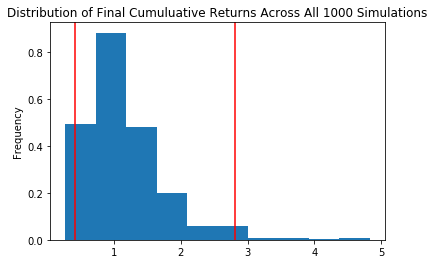

In [27]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           1000.000000
mean               1.155800
std                0.594451
min                0.272316
25%                0.756091
50%                1.034649
75%                1.380844
max                4.826188
95% CI Lower       0.424386
95% CI Upper       2.813575
Name: 1260, dtype: float64


In [29]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $6365.78 and $42203.63.


### Summarize findings across all 4 simulations

YOUR ANSWER HERE!